# Import

In [62]:
import math
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# print(os.environ.keys())
dir_item = '/home/jake/Documents/News_Item/'
dir_proj = dir_item + 'Private_Education/'
dir_tableau = dir_proj + 'tableau_data/'

# Load

In [33]:
sheets = pd.read_excel('/home/jake/Documents/News_Item/Private_Education/seoul_171231.xls', sheet_name=None, thousands=',')

cols = '학원명', '학원종류', '분야구분', '학원주소', '설립자-성명', '전화번호', '교습계열', '교습과정', '교습과목(반)', '정원', '교습기간', '총교습시간(분)', '교습비', '총교습비', '강사수',

df = pd.DataFrame()
for sh in sheets.values():
    df = df.append(sh.loc[::, cols])

del sheets

df['교습과목(반)'].fillna('', inplace=True)
df['설립자-성명2'] = df['설립자-성명'].fillna('')
print(df.shape)
df.head()

(153822, 16)


,학원명,학원종류,분야구분,학원주소,설립자-성명,전화번호,교습계열,교습과정,교습과목(반),정원,교습기간,총교습시간(분),교습비,총교습비,강사수,설립자-성명2
0,청량리도우리이발기술학원,평생직업교육학원,직업기술,"서울특별시 동대문구 왕산로33길 32 , 2층 (제기동)",박영배,02-969-5025,산업응용기술,이·미용,이발기술,20.0,1개월 0일,3780.0,150000.0,150000.0,1,박영배
1,대성회계실무학원,평생직업교육학원,종합(대),"서울특별시 동대문구 왕산로 225 , 5층2호, 5층6호 (청량리동)",대성회계실무학원(주),02-966-8400,NaN,NaN,전산회계1급,13.0,2개월 0일,4500.0,481430.0,481430.0,6,대성회계실무학원(주)
2,대성회계실무학원,평생직업교육학원,종합(대),"서울특별시 동대문구 왕산로 225 , 5층2호, 5층6호 (청량리동)",대성회계실무학원(주),02-966-8400,NaN,NaN,전산세무2급,19.0,2개월 0일,4320.0,462170.0,462170.0,6,대성회계실무학원(주)
3,대성회계실무학원,평생직업교육학원,종합(대),"서울특별시 동대문구 왕산로 225 , 5층2호, 5층6호 (청량리동)",대성회계실무학원(주),02-966-8400,NaN,NaN,전산세무1급(법인세무조정),19.0,0개월 21일,3600.0,385140.0,385140.0,6,대성회계실무학원(주)
4,대성회계실무학원,평생직업교육학원,종합(대),"서울특별시 동대문구 왕산로 225 , 5층2호, 5층6호 (청량리동)",대성회계실무학원(주),02-966-8400,NaN,NaN,"(초급,중급)전산회계1급 및 전산세무2급 자격증반(케이렙+더존(AT))",25.0,2개월 14일,15600.0,1660000.0,1660000.0,6,대성회계실무학원(주)


# Add '지역'

In [34]:
print(df['학원주소'].isna().sum())

0


In [35]:
def get_df_region_added(df):
    def get_region_from_address(addr):
        list_region = ['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구',]        
        words = addr.split()
        for region in list_region:
            if region in addr:
                return region
        else:
            return None
    df['지역'] = df['학원주소'].apply(get_region_from_address)
    return df

df = get_df_region_added(df)
df.head(1)

,학원명,학원종류,분야구분,학원주소,설립자-성명,전화번호,교습계열,교습과정,교습과목(반),정원,교습기간,총교습시간(분),교습비,총교습비,강사수,설립자-성명2,지역
0,청량리도우리이발기술학원,평생직업교육학원,직업기술,"서울특별시 동대문구 왕산로33길 32 , 2층 (제기동)",박영배,02-969-5025,산업응용기술,이·미용,이발기술,20.0,1개월 0일,3780.0,150000.0,150000.0,1,박영배,동대문구


In [36]:
print(df.shape)
print(df['지역'].value_counts().sum())
df.loc[df['지역'].isna(), ['학원주소']]

(153822, 17)
153822


,학원주소


# Add '시간당교습비'

In [66]:

def get_fee_per_hour(row):
    if (row['총교습시간(분)'] == 0) or (row['분야구분']=='독서실'):
        return 0
    else:
        return row['총교습비'] / row['총교습시간(분)'] * 60

# df['시간당교습비'] = df['총교습비'] / df['총교습시간(분)'] * 60 if df['총교습시간(분)'] != 0 else 0

df['시간당교습비'] = df.apply(get_fee_per_hour, axis=1)
df['시간당매출'] = df['정원'] * df['시간당교습비']
df['총매출'] = df['정원'] * df['총교습비']

df.head(1)

,학원명,학원종류,분야구분,학원주소,설립자-성명,전화번호,교습계열,교습과정,교습과목(반),정원,교습기간,총교습시간(분),교습비,총교습비,강사수,설립자-성명2,지역,시간당교습비,시간당매출,총매출
0,청량리도우리이발기술학원,평생직업교육학원,직업기술,"서울특별시 동대문구 왕산로33길 32 , 2층 (제기동)",박영배,02-969-5025,산업응용기술,이·미용,이발기술,20.000,1개월 0일,3780.000,150000.000,150000.000,1,박영배,동대문구,2380.952,47619.048,3000000.000


# 분야구분

In [67]:
print(df['분야구분'].value_counts().sum())
df['분야구분'].value_counts()

153822


입시.검정 및 보습    75003
예능(대)         15434
인문사회(대)       14810
국제화           14483
종합(대)         12360
직업기술          10940
기예(대)          4200
독서실            3912
기타(대)          2669
특수교육(대)          11
Name: 분야구분, dtype: int64

# 교습계열

In [68]:
print(df['교습계열'].value_counts().sum())
df['교습계열'].value_counts()

142119


보통교과       74819
예능(중)      15458
인문사회(중)    14810
외국어         7749
국제          6790
산업응용기술      5596
기예(중)       4204
독서실         3105
기타(중)       2672
컴퓨터         2618
산업기반기술      1498
독서실(중)       807
산업서비스        438
경영·사무관리      361
진학지도         342
종합           316
문화관광         219
일반서비스        163
간호보조기술       143
특수교육(중)       11
Name: 교습계열, dtype: int64

# 교습과정

In [69]:
print(df['교습과정'].value_counts().sum())
df['교습과정'].value_counts()

142203


보습                          59675
보습·논술                       14749
성인고시                        14029
음악                           9048
실용외국어(유아/초·중·고)              7714
어학(성인)                       6361
미술                           5632
독서실(유아/초·중·고)                3053
식음료품(바리스타,소믈리에)              2469
컴퓨터(정보처리,통신기기,인터넷,소프트웨어)     2416
이·미용                         1915
실용음악(성악)                     1808
디자인                          1066
무용                           1057
기타(소)                         827
독서실(일반인)                      807
연극                            674
댄스                            656
무용(전통무용,현대무용)                 396
공예(종이접기,꽃꽂이,꽃기예)              377
회계                            347
컴퓨터(소)                        342
진학상담지도                        340
통역(성인)                        335
전기                            325
종합                            316
화술                            314
연기(연극,뮤지컬,오페라)                260
경영                            242
의복            

# 교습과정 단어구름

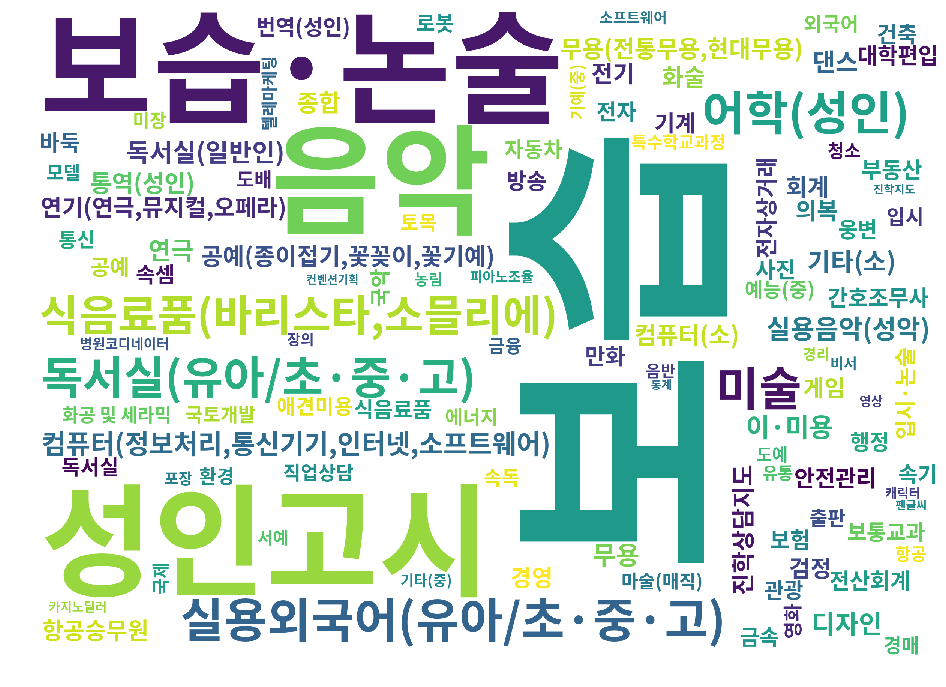

In [70]:
plt.figure(figsize=(20, 12))
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc'
word_frequencies = df['교습과정'].value_counts().to_dict()

# The frequencies too wide. Get log values
word_frequencies['통계'] = 2  # Avoid log(1) = 0
word_frequencies['컨벤션기획'] = 2
word_freq_log2 = {k: math.log1p(v) for k, v in word_frequencies.items()}

wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False, width=2400, height=1740, font_path=font_path).generate_from_frequencies(word_freq_log2)
plt.imshow(wordcloud)
# plt.title('Lecture Types')
plt.axis('off')
plt.show()

# 진학지도: 과목

In [71]:
def get_total_fee_by_region(df):
    return df.groupby('지역').agg({'총교습비': 'describe'}).sort_values(('총교습비', 'mean'), ascending=False)


idx_consulting = df['교습계열']=='진학지도'
print(get_total_fee_by_region(df.loc[idx_consulting])[('총교습비', 'count')].sum())
get_total_fee_by_region(df.loc[idx_consulting])

342.0


총교습비                                                           \
       count        mean         std        min        25%        50%   
지역                                                                      
강남구  175.000 1087531.429 1222926.539  30000.000 350000.000 600000.000   
금천구    8.000  687500.000  463488.326 200000.000 300000.000 625000.000   
서초구   38.000  606351.316  524573.636   2850.000 300000.000 400000.000   
양천구   68.000  383529.412  323323.251  26000.000 187750.000 300000.000   
노원구   15.000  335333.333  196282.110  40000.000 200000.000 300000.000   
영등포구   9.000  300000.000   70710.678 200000.000 300000.000 300000.000   
송파구    8.000  252250.000  147827.844  50000.000 175000.000 234000.000   
마포구   21.000   65485.714   17593.977  35750.000  55000.000  67500.000   

                              
             75%         max  
지역                            
강남구  1370000.000 8200000.000  
금천구   862500.000 1500000.000  
서초구   750000.000 2160000.000  
양천구   466250.000 1800000.000  
노원구   400000.000  800000.000  
영등포구  300000.000  400000.000  
송파구   325000.000  500000.000  
마포구    75000.000   99000.000

실제로 강남구에 진학지도 학원이 제일 많다. 가격도 적지않은편. 평균 108만, 가장 비싼 곳은 820만원

# 진학지도: 학원

In [72]:
def get_df_institute_from_lecture(df):
    return df.groupby(['학원명', '학원주소', '설립자-성명2']).agg({'총교습비': 'count'})

# df.loc[idx_consulting]

def get_df_inst_region_from_df_inst(df):
    df = df.rename(columns={'총교습비': '과목수'})
    df = df.reset_index()
    df = get_df_region_added(df)
    return df

df_inst_region = get_df_institute_from_lecture(df.loc[idx_consulting])
print(df_inst_region.columns)
# df_inst_cnst.rename(columns={'총교습비': '과목수'}, inplace=True)
# df_inst_cnst.reset_index(inplace=True)
# df_inst_cnst = get_df_region_added(df_inst_cnst)
df_inst_region = get_df_inst_region_from_df_inst(df_inst_region)
print(len(df_inst_region))
print(df_inst_region['지역'].value_counts())
df_inst_region

Index(['총교습비'], dtype='object')
40
강남구     20
서초구      8
양천구      4
노원구      3
송파구      2
영등포구     1
마포구      1
금천구      1
Name: 지역, dtype: int64


,학원명,학원주소,설립자-성명2,과목수,지역
0,PrimeGMS학원,서울특별시 노원구 한글비석로 272 중원코아빌딩 501호,(주)프라임지엠에스,1,노원구
1,거인의어깨교육연구소학원,"서울특별시 강남구 역삼로 546 , 7층 (대치동,덕일빌딩)",(주)메킨드,3,강남구
2,공부혁명대대치점학원,"서울특별시 강남구 선릉로64길 18 , 2층 (대치동)",주식회사에스지공부법연구소,4,강남구
3,공부혁명대목동점학원,"서울특별시 양천구 목동동로 228-4 , 2층, 3층 (목동)",주식회사에스지공부법연구소,4,양천구
4,김영일교육컨설팅학원,"서울특별시 강남구 도곡로13길 6 , 2층 (역삼동,석영빌딩)",김영일교육컨설팅(주),9,강남구
5,김필립수학전문학원,"서울특별시 양천구 오목로 279 , 506호 (목동, 현대프라자)",(주)필립교육그룹,6,양천구
6,꿈과가치컨설팅학원,"서울특별시 금천구 디지털로9길 47 , 405호(한신IT TOWER Ⅱ) (가산동)",하재철,8,금천구
7,대신교육입시내비게이션학원,"서울특별시 강남구 도산대로8길 18-9 , 2층 (논현동)",신재호,1,강남구
8,더입시플렉스학원,"서울특별시 강남구 선릉로64길 8 , 3층 (대치동)",조민주,17,강남구
9,드림폴리오학원,"서울특별시 양천구 오목로 299 , 트라팰리스 웨스턴에비뉴 604호 (목동)",주식회사코리아폴리스쿨,11,양천구


# Export: 지역별학원

In [73]:
df_export_region = df_inst_region['지역'].value_counts().to_frame().reset_index().rename(columns={'index': '지역', '지역': '학원수'})
# df_export_region.to_csv(dir_tableau + 'inst_by_region.tsv', sep='\t', index=False)

# 진학지도: 동네 분류

In [74]:
df_inst_region['학원주소']

0                  서울특별시 노원구 한글비석로 272 중원코아빌딩 501호  
1                  서울특별시 강남구 역삼로 546 , 7층 (대치동,덕일빌딩)
2                     서울특별시 강남구 선릉로64길 18 , 2층 (대치동)
3                 서울특별시 양천구 목동동로 228-4 , 2층, 3층 (목동)
4                 서울특별시 강남구 도곡로13길 6 , 2층 (역삼동,석영빌딩)
5               서울특별시 양천구 오목로 279 , 506호 (목동, 현대프라자)
6     서울특별시 금천구 디지털로9길 47 , 405호(한신IT TOWER Ⅱ) (가산동)
7                   서울특별시 강남구 도산대로8길 18-9 , 2층 (논현동)
8                      서울특별시 강남구 선릉로64길 8 , 3층 (대치동)
9         서울특별시 양천구 오목로 299 , 트라팰리스 웨스턴에비뉴 604호 (목동)
10              서울특별시 송파구 양재대로 1164 , 4층, 403호 (오금동)
11                    서울특별시 강남구 삼성로 233 , 308호 (대치동)
12                    서울특별시 강남구 선릉로64길 18 , 4층 (대치동)
13     서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)
14            서울특별시 노원구 중계로18길 17 , 303호, 304호 (중계동)
15                     서울특별시 강남구 선릉로66길 9 , 2층 (대치동)
16              서울특별시 강남구 테헤란로64길 16-9 , 3층,4층 (대치동)
17                      서울특별시 강남구 삼성로 313 , 4층 (대치동)
18                  서울특별시 강남구 삼성로 319 , 6층, 7층

강남구: 대치동 16, 논현동 2, 역삼동 2  
서초구: 서초동 4, 반포동 2, 양재동 1, 잠원동 1  
양천구: 목동 4  
노원구: 중계동 3  
송파구: 오금동 1, 삼전동 1  
금천구: 가산동 1  
영등포구: 여의도동 1  
마포구: 서교동 1

# 진학지도: 교습비

In [75]:
idx_gangnam = df['지역'] == '강남구'
df.loc[idx_consulting & idx_gangnam].sort_values('시간당교습비', ascending=False)

,학원명,학원종류,분야구분,학원주소,설립자-성명,전화번호,교습계열,교습과정,교습과목(반),정원,교습기간,총교습시간(분),교습비,총교습비,강사수,설립자-성명2,지역,시간당교습비,시간당매출,총매출
11910,휴브레인입시컨설팅센터학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 역삼로 462 , 2층 (대치동)",(주)디와이교육,02-558-9283,진학지도,진학상담지도,입시로드맵컨설팅(단기),1.000,1개월 0일,30.000,150000.000,150000.000,18,(주)디와이교육,강남구,300000.000,300000.000,150000.000
30426,미래비전컨설팅학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 선릉로64길 18 , 4층 (대치동)",주식회사미래비전컨설팅,02-555-1298,진학지도,진학상담지도,진학지도8,10.000,1개월 0일,90.000,450000.000,450000.000,35,주식회사미래비전컨설팅,강남구,300000.000,3000000.000,4500000.000
25971,열정스토리학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 도곡로 409 , 403호 (대치동,타워엠프리스)",조근주,02-501-7115,진학지도,진학상담지도,중학생 정규반,1.000,3개월 0일,300.000,1500000.000,1500000.000,1,조근주,강남구,300000.000,300000.000,1500000.000
25972,열정스토리학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 도곡로 409 , 403호 (대치동,타워엠프리스)",조근주,02-501-7115,진학지도,진학상담지도,고등학생 정규반,1.000,3개월 0일,360.000,1800000.000,1800000.000,1,조근주,강남구,300000.000,300000.000,1800000.000
25973,열정스토리학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 도곡로 409 , 403호 (대치동,타워엠프리스)",조근주,02-501-7115,진학지도,진학상담지도,중학생 6개월반,1.000,6개월 0일,600.000,3000000.000,3000000.000,1,조근주,강남구,300000.000,300000.000,3000000.000
25974,열정스토리학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 도곡로 409 , 403호 (대치동,타워엠프리스)",조근주,02-501-7115,진학지도,진학상담지도,고등학생 6개월반,1.000,6개월 0일,720.000,3600000.000,3600000.000,1,조근주,강남구,300000.000,300000.000,3600000.000
25975,열정스토리학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 도곡로 409 , 403호 (대치동,타워엠프리스)",조근주,02-501-7115,진학지도,진학상담지도,진로 진학 상담,1.000,1개월 0일,120.000,600000.000,600000.000,1,조근주,강남구,300000.000,300000.000,600000.000
25976,열정스토리학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 도곡로 409 , 403호 (대치동,타워엠프리스)",조근주,02-501-7115,진학지도,진학상담지도,진학파이널반,1.000,4개월 0일,720.000,3600000.000,3600000.000,1,조근주,강남구,300000.000,300000.000,3600000.000
29080,더입시플렉스학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 선릉로64길 8 , 3층 (대치동)",조민주,02-6080-7227,진학지도,진학상담지도,전략A,1.000,1개월 0일,60.000,300000.000,300000.000,1,조민주,강남구,300000.000,300000.000,300000.000
29081,더입시플렉스학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 선릉로64길 8 , 3층 (대치동)",조민주,02-6080-7227,진학지도,진학상담지도,전략B,1.000,1개월 0일,120.000,600000.000,600000.000,1,조민주,강남구,300000.000,300000.000,600000.000


# 진학지도: 교습비 30만원

In [76]:
idx_30 = df['시간당교습비'] == 300000
print(len(df.loc[idx_consulting & idx_30]))
print(len(get_df_institute_from_lecture(df.loc[idx_consulting & idx_30])))

df_inst_30 = get_df_institute_from_lecture(df.loc[idx_consulting & idx_30])
df_inst_30 = get_df_inst_region_from_df_inst(df_inst_30)

print(df_inst_30['지역'].value_counts())
df_inst_30

51
16
강남구    13
서초구     3
Name: 지역, dtype: int64


,학원명,학원주소,설립자-성명2,과목수,지역
0,김영일교육컨설팅학원,"서울특별시 강남구 도곡로13길 6 , 2층 (역삼동,석영빌딩)",김영일교육컨설팅(주),8,강남구
1,대신교육입시내비게이션학원,"서울특별시 강남구 도산대로8길 18-9 , 2층 (논현동)",신재호,1,강남구
2,더입시플렉스학원,"서울특별시 강남구 선릉로64길 8 , 3층 (대치동)",조민주,7,강남구
3,미래비전컨설팅학원,"서울특별시 강남구 선릉로64길 18 , 4층 (대치동)",주식회사미래비전컨설팅,2,강남구
4,바른길입시교육컨설팅2관학원,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,1,강남구
5,비전과멘토학원,"서울특별시 강남구 선릉로66길 9 , 2층 (대치동)",(주)비전과멘토,4,강남구
6,스터디뉴스입시센터학원,"서울특별시 강남구 삼성로 313 , 4층 (대치동)",(주)더블유에이치와이,1,강남구
7,열정스토리학원,"서울특별시 강남구 도곡로 409 , 403호 (대치동,타워엠프리스)",조근주,6,강남구
8,유웨이중앙교육컨설팅학원,"서울특별시 서초구 고무래로 6-6 , 선경빌딩 4층 일부 (반포동)",유웨이중앙교육,3,서초구
9,이지에듀학원,"서울특별시 서초구 논현로 121 , 7층,8층 (양재동, 두일빌딩)",(주)이지수능,1,서초구


# 진학지도: groupby 교습비

In [77]:
def get_df_institute_from_lecture_by_fee(df):
    return df.groupby(['학원명', '학원주소', '설립자-성명2']).agg({'시간당교습비': 'max'})

# df.loc[idx_consulting]

def get_df_inst_region_from_df_inst_by_fee(df):
#     df = df.rename(columns={'시간당교습비': ''})
    df = df.reset_index()
    df = get_df_region_added(df)
    return df

df_inst_fee = get_df_institute_from_lecture_by_fee(df.loc[idx_consulting])
df_inst_fee = get_df_inst_region_from_df_inst_by_fee(df_inst_fee)
# df_inst_fee.sort_values('시간당교습비', ascending=False)
print(len(df_inst_fee))
df_inst_fee['시간당교습비'].value_counts()  # 30만원: 40%

40


300000.000    16
250000.000     3
225000.000     2
5700.000       2
11142.857      2
233333.333     1
240000.000     1
30000.000      1
171428.571     1
11337.868      1
100000.000     1
133333.333     1
257142.857     1
150000.000     1
13809.524      1
173076.923     1
84857.143      1
246000.000     1
11904.762      1
12000.000      1
Name: 시간당교습비, dtype: int64

Text(0.5, 1.0, '시간당교습비')

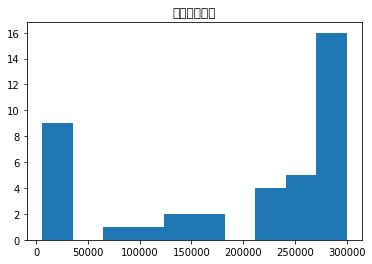

In [78]:
plt.hist(df_inst_fee['시간당교습비'])
plt.title('시간당교습비')

# 진학지도: 한달매출

In [100]:
def add_total_sales_per_month(row):
    import re
    obj = re.search(r'(\d)개월 (\d)일', row['교습기간'])
    if not obj:
        return 0
    else:
        months, days = int(obj.group(1)), int(obj.group(2))
        divisor = (months + (days/30))
        if divisor == 0:
            return 0
        else:
            total_sales_per_month = row['총매출'] / divisor
            return total_sales_per_month

df.loc[idx_consulting, '한달매출'] = df.loc[idx_consulting].apply(add_total_sales_per_month, axis=1)
df.loc[idx_consulting].head()

,학원명,학원종류,분야구분,학원주소,설립자-성명,전화번호,교습계열,교습과정,교습과목(반),정원,교습기간,총교습시간(분),교습비,총교습비,강사수,설립자-성명2,지역,시간당교습비,시간당매출,총매출,한달매출
10139,인강백서특자단원격학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 마포구 동교로19길 19 , 2층 좌측 (서교동)",(주)스위치마케팅그룹,070-5056-1034,진학지도,진학상담지도,(고입)특목고 자기소개서,1000.000,1개월 0일,567.000,75000.000,75000.000,14,(주)스위치마케팅그룹,마포구,7936.508,7936507.937,75000000.000,75000000.000
10140,인강백서특자단원격학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 마포구 동교로19길 19 , 2층 좌측 (서교동)",(주)스위치마케팅그룹,070-5056-1034,진학지도,진학상담지도,(고입)특목고 면접,1000.000,1개월 0일,378.000,55000.000,55000.000,14,(주)스위치마케팅그룹,마포구,8730.159,8730158.730,55000000.000,55000000.000
10141,인강백서특자단원격학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 마포구 동교로19길 19 , 2층 좌측 (서교동)",(주)스위치마케팅그룹,070-5056-1034,진학지도,진학상담지도,(고입)자사고 자기소개서,1000.000,1개월 0일,567.000,75000.000,75000.000,14,(주)스위치마케팅그룹,마포구,7936.508,7936507.937,75000000.000,75000000.000
10142,인강백서특자단원격학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 마포구 동교로19길 19 , 2층 좌측 (서교동)",(주)스위치마케팅그룹,070-5056-1034,진학지도,진학상담지도,(고입)자사고 면접,1000.000,1개월 0일,378.000,55000.000,55000.000,14,(주)스위치마케팅그룹,마포구,8730.159,8730158.730,55000000.000,55000000.000
10143,인강백서특자단원격학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 마포구 동교로19길 19 , 2층 좌측 (서교동)",(주)스위치마케팅그룹,070-5056-1034,진학지도,진학상담지도,(고입)과학고 자기소개서,1000.000,1개월 0일,567.000,75000.000,75000.000,14,(주)스위치마케팅그룹,마포구,7936.508,7936507.937,75000000.000,75000000.000


# 진학지도: 과목별 한달매출

In [103]:
df[idx_consulting].sort_values('한달매출', ascending=False).head()

,학원명,학원종류,분야구분,학원주소,설립자-성명,전화번호,교습계열,교습과정,교습과목(반),정원,교습기간,총교습시간(분),교습비,총교습비,강사수,설립자-성명2,지역,시간당교습비,시간당매출,총매출,한달매출
31463,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,자기소개서H(Final),75.000,0개월 1일,360.000,1000000.000,1000000.000,41,(주)바른길진로교육,강남구,166666.667,12500000.000,75000000.000,2250000000.000
31452,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,입시 전략 상담,75.000,0개월 1일,60.000,300000.000,300000.000,41,(주)바른길진로교육,강남구,300000.000,22500000.000,22500000.000,675000000.000
27828,이지에듀학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 서초구 논현로 121 , 7층,8층 (양재동, 두일빌딩)",(주)이지수능,02-571-8170,진학지도,진학상담지도,소논문멘토링,10.000,0개월 1일,400.000,2000000.000,2000000.000,28,(주)이지수능,서초구,300000.000,3000000.000,20000000.000,600000000.000
31451,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,진로 진학 상담,75.000,0개월 1일,60.000,200000.000,200000.000,41,(주)바른길진로교육,강남구,200000.000,15000000.000,15000000.000,450000000.000
31460,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,면접 프로그램 A,75.000,0개월 4일,720.000,650000.000,650000.000,41,(주)바른길진로교육,강남구,54166.667,4062500.000,48750000.000,365625000.000


# 진학지도: 학원별 한달매출

In [105]:
def get_grouped_inst_agg_month_sales(df):
    return df.groupby(['학원명', '학원주소', '설립자-성명2']).agg({'한달매출': 'sum'})


# def get_df_inst_region_from_df_inst(df):
#     df = df.rename(columns={'총교습비': '과목수'})
#     df = df.reset_index()
#     df = get_df_region_added(df)
#     return df


df_inst_sales = get_grouped_inst_agg_month_sales(df.loc[idx_consulting])
df_inst_sales.sort_values('한달매출', ascending=False)

,,,한달매출
학원명,학원주소,설립자-성명2,
바른길입시교육컨설팅2관학원,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,4999020000.000
인강백서특자단원격학원,"서울특별시 마포구 동교로19길 19 , 2층 좌측 (서교동)",(주)스위치마케팅그룹,1375200000.000
이지에듀학원,"서울특별시 서초구 논현로 121 , 7층,8층 (양재동, 두일빌딩)",(주)이지수능,1140000000.000
토마스아카데미5관학원,"서울특별시 양천구 신목로 58-9 , 4층(신정동, 인성빌딩) (신정동)",주식회사업스터디,916700000.000
리더스플랜학원,"서울특별시 강남구 삼성로 233 , 308호 (대치동)",(주)리더스플랜컴패니,636000000.000
더입시플렉스학원,"서울특별시 강남구 선릉로64길 8 , 3층 (대치동)",조민주,610100000.000
꿈과가치컨설팅학원,"서울특별시 금천구 디지털로9길 47 , 405호(한신IT TOWER Ⅱ) (가산동)",하재철,297000000.000
미래비전컨설팅학원,"서울특별시 강남구 선릉로64길 18 , 4층 (대치동)",주식회사미래비전컨설팅,227500000.000
이병훈교육연구소진로진학학원,"서울특별시 강남구 역삼로 423 , 5층 (대치동)",(주)시공학원,126000000.000


# 바른길진로학원?

In [106]:
df.loc[idx_consulting & (df['학원명']=='바른길입시교육컨설팅2관학원')]

,학원명,학원종류,분야구분,학원주소,설립자-성명,전화번호,교습계열,교습과정,교습과목(반),정원,교습기간,총교습시간(분),교습비,총교습비,강사수,설립자-성명2,지역,시간당교습비,시간당매출,총매출,한달매출
31451,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,진로 진학 상담,75.000,0개월 1일,60.000,200000.000,200000.000,41,(주)바른길진로교육,강남구,200000.000,15000000.000,15000000.000,450000000.000
31452,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,입시 전략 상담,75.000,0개월 1일,60.000,300000.000,300000.000,41,(주)바른길진로교육,강남구,300000.000,22500000.000,22500000.000,675000000.000
31453,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,입시 상담,75.000,0개월 1일,60.000,150000.000,150000.000,41,(주)바른길진로교육,강남구,150000.000,11250000.000,11250000.000,337500000.000
31454,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,자기소개서A 프리미엄 완성,75.000,1개월 0일,360.000,1250000.000,1250000.000,41,(주)바른길진로교육,강남구,208333.333,15625000.000,93750000.000,93750000.000
31455,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,자기소개서B 대학별 완성,75.000,1개월 0일,360.000,700000.000,700000.000,41,(주)바른길진로교육,강남구,116666.667,8750000.000,52500000.000,52500000.000
31456,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,자기소개서Z 프리미엄 완성,75.000,1개월 0일,300.000,1000000.000,1000000.000,41,(주)바른길진로교육,강남구,200000.000,15000000.000,75000000.000,75000000.000
31457,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,자기소개서B’ 프리미엄 완성,75.000,1개월 0일,300.000,600000.000,600000.000,41,(주)바른길진로교육,강남구,120000.000,9000000.000,45000000.000,45000000.000
31458,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,자기소개서S 프리미엄 완성,75.000,2개월 0일,600.000,2250000.000,2250000.000,41,(주)바른길진로교육,강남구,225000.000,16875000.000,168750000.000,84375000.000
31459,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,자기소개서 첨삭,75.000,1개월 0일,180.000,350000.000,350000.000,41,(주)바른길진로교육,강남구,116666.667,8750000.000,26250000.000,26250000.000
31460,바른길입시교육컨설팅2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 삼성로 155 , 509호,510호,511호,512호 (대치동)",(주)바른길진로교육,02-1544-6225,진학지도,진학상담지도,면접 프로그램 A,75.000,0개월 4일,720.000,650000.000,650000.000,41,(주)바른길진로교육,강남구,54166.667,4062500.000,48750000.000,365625000.000


# Export: 학원별 교습비

In [79]:
# df_inst_fee.to_csv(dir_tableau + 'fee_by_inst.tsv', sep='\t', index=False)

# 보습학원

In [80]:
idx_entrance = df['분야구분']=='입시.검정 및 보습'

# df.loc[idx_entrance].groupby('지역').agg({'총교습비': 'describe'}).sort_values(('총교습비', 'mean'), ascending=False)
# print(len(df.loc[df['학원종류']=='학교교과교습학원']))

print("과목수: ", len(df.loc[idx_entrance]))

# df.loc[idx_entrance].head()
df_lecture = get_df_institute_from_lecture(df.loc[idx_entrance])
df_lecture = get_df_inst_region_from_df_inst(df_lecture)
print("학원수: ", len(df_lecture))
df_lecture.head()
# df.loc[df['학원종류']=='학교교과교습학원', '분야구분'].value_counts()

과목수:  75003
학원수:  7448


,학원명,학원주소,설립자-성명2,과목수,지역
0,(상계분원)오메가수학학원,"서울특별시 노원구 한글비석로 460 , 3층일부 (상계동,백산빌딩)",박종길,6,노원구
1,(주)그루샘수학보습학원,"서울특별시 강남구 도곡로 451 , 5층 (대치동,한나빌딩)",(주)그루샘수학보습학원,14,강남구
2,(주)멘토르수학전문학원,"서울특별시 강남구 남부순환로 2909 , 302호 (대치동)",(주)멘토르수학전문학원,2,강남구
3,(주)산에듀김영준국어논술전문별관학원,"서울특별시 강남구 선릉로62길 27 , 1~4층 (대치동)",(주)산에듀,7,강남구
4,(주)산에듀김영준국어논술전문학원,"서울특별시 강남구 도곡로 409 , 2층 (대치동,타워엠프리스)",(주)산에듀,6,강남구


# 보습학원: 지역별

In [81]:
tmp = df_lecture['지역'].value_counts()
total = tmp.sum()
print(tmp.sum())
# tmp/total*100
pd.DataFrame(data=[tmp, tmp/total*100]).T

7448


,지역,지역
강남구,1063.000,14.272
양천구,689.000,9.251
송파구,642.000,8.620
서초구,542.000,7.277
노원구,461.000,6.190
강서구,407.000,5.465
강동구,399.000,5.357
은평구,353.000,4.740
성북구,278.000,3.733
마포구,227.000,3.048


# 교습비

In [82]:
df['총교습비'].describe()

count     153731.000
mean      420482.407
std       694791.751
min            0.000
25%       150000.000
50%       250000.000
75%       400000.000
max     63110401.000
Name: 총교습비, dtype: float64

금천구 학원비 9만원.. 뭐지? => 원격학원이 많다

In [83]:
# df.loc[idx_entrance & (df['지역']=='금천구') & (df['총교습비'] <= 90000)]

# 컨설팅 학원 소분류?

In [84]:
df.loc[idx_consulting, '교습과정'].value_counts()

진학상담지도    340
진학지도        2
Name: 교습과정, dtype: int64

# 초등 대상 학원 얼마나 많은지?

In [85]:
df['교습과목(반)'].isna().sum()

0

In [86]:
idx_school = df['학원종류'] == '학교교과교습학원'
idx_elementary = df['교습과목(반)'].str.contains('초등')

print(df.loc[idx_school].shape)
print(df.loc[idx_school&idx_elementary].shape)
df.loc[idx_school&idx_elementary].head()

(108993, 20)
(17858, 20)


,학원명,학원종류,분야구분,학원주소,설립자-성명,전화번호,교습계열,교습과정,교습과목(반),정원,교습기간,총교습시간(분),교습비,총교습비,강사수,설립자-성명2,지역,시간당교습비,시간당매출,총매출
35,예맥보습학원,학교교과교습학원,입시.검정 및 보습,서울특별시 중랑구 동일로151길 30 2층3층 (묵동),조소정,02-974-6751,보통교과,보습,"초등(국,영,수)",3.000,1개월 0일,3150.000,155000.000,155000.000,2,조소정,중랑구,2952.381,8857.143,465000.000
36,예맥보습학원,학교교과교습학원,입시.검정 및 보습,서울특별시 중랑구 동일로151길 30 2층3층 (묵동),조소정,02-974-6751,보통교과,보습,"초등(국,영,수,사,과)",3.000,1개월 0일,3150.000,255000.000,255000.000,2,조소정,중랑구,4857.143,14571.429,765000.000
41,세진보습학원,학교교과교습학원,입시.검정 및 보습,서울특별시 중랑구 공릉로 58 2층4층일부 (묵동),이슬기,02-978-8383,보통교과,보습,초등단과(수학),10.000,1개월 0일,1050.000,150000.000,150000.000,4,이슬기,중랑구,8571.429,85714.286,1500000.000
42,세진보습학원,학교교과교습학원,입시.검정 및 보습,서울특별시 중랑구 공릉로 58 2층4층일부 (묵동),이슬기,02-978-8383,보통교과,보습,초등연합,10.000,1개월 0일,2310.000,330000.000,330000.000,4,이슬기,중랑구,8571.429,85714.286,3300000.000
46,세진보습학원,학교교과교습학원,입시.검정 및 보습,서울특별시 중랑구 공릉로 58 2층4층일부 (묵동),이슬기,02-978-8383,보통교과,보습,"초등(영어,수학)",10.000,1개월 0일,1890.000,300000.000,300000.000,4,이슬기,중랑구,9523.810,95238.095,3000000.000


In [87]:
df.loc[idx_school&idx_elementary].groupby('지역').agg({'총교습비': 'describe'}).sort_values(('총교습비', 'count'), ascending=False)


총교습비                                                        \
        count       mean        std       min        25%        50%   
지역                                                                    
양천구  1574.000 217822.675 102160.297 10000.000 150000.000 200000.000   
강서구  1456.000 184337.912  80963.941 10000.000 140000.000 180000.000   
송파구  1371.000 221043.901 123483.489   588.000 150000.000 200000.000   
강남구  1271.000 309028.080 209767.707     0.000 200000.000 289000.000   
노원구  1107.000 177655.556  86343.598     0.000 130000.000 170000.000   
성북구   959.000 205393.743  99614.989 34000.000 150000.000 190000.000   
은평구   806.000 175936.352  71111.670 10000.000 150000.000 170000.000   
강동구   786.000 186274.936  75621.992 20000.000 150000.000 180000.000   
영등포구  752.000 185930.652 105658.961  1000.000 120000.000 190000.000   
서초구   729.000 267944.650 149997.828 17500.000 180000.000 250000.000   
동대문구  670.000 185387.612  91079.818 15000.000 130000.000 177500.000   
구로구   666.000 185935.285  74831.388     0.000 150000.000 177000.000   
광진구   638.000 208635.204 115647.589     0.000 150000.000 190000.000   
도봉구   599.000 179535.893  79724.153 20000.000 130000.000 170000.000   
관악구   587.000 168292.675  82197.138 25000.000 120000.000 160000.000   
마포구   581.000 199215.146  88445.384  3000.000 150000.000 195000.000   
서대문구  547.000 187686.472  67484.844 20000.000 150000.000 180000.000   
동작구   545.000 178478.165  83803.162 28000.000 126000.000 170000.000   
중랑구   530.000 185284.434  83034.929 15000.000 140000.000 170000.000   
강북구   464.000 177026.940  76236.034 15000.000 130000.000 170000.000   
성동구   426.000 192541.362  79612.453 20000.000 150000.000 180000.000   
금천구   305.000 184550.803  80238.547 10000.000 142000.000 180000.000   
용산구   222.000 197283.514  88753.385 40000.000 146250.000 180000.000   
종로구   135.000 167807.407  89811.452 12000.000 110000.000 160000.000   
중구    132.000 197841.970  84407.261 48000.000 149000.000 185500.000   

                             
            75%         max  
지역                           
양천구  270000.000  992250.000  
강서구  230000.000  730000.000  
송파구  266500.000 2200000.000  
강남구  380000.000 3591000.000  
노원구  228500.000  516000.000  
성북구  250000.000  640000.000  
은평구  200000.000  600000.000  
강동구  220000.000  669000.000  
영등포구 250000.000  650600.000  
서초구  330000.000 1868000.000  
동대문구 220000.000  650000.000  
구로구  220000.000  621000.000  
광진구  250000.000 1280000.000  
도봉구  220000.000  440000.000  
관악구  200000.000  500000.000  
마포구  240000.000  650000.000  
서대문구 210000.000  600000.000  
동작구  220000.000  573000.000  
중랑구  238800.000  698000.000  
강북구  210000.000  530500.000  
성동구  240000.000  590000.000  
금천구  230000.000  540323.000  
용산구  240000.000  540000.000  
종로구  200000.000  480000.000  
중구   261000.000  460000.000

# 학원 개수?

In [88]:

print(df['학원주소'].isna().sum())
print(df['설립자-성명'].isna().sum())

print(len(df.groupby('설립자-성명').agg({'총교습비': 'count'})))
# df.loc[df['설립자-성명'].isna(), ['학원명', '학원주소']]

print(len(df.groupby('설립자-성명2').agg({'총교습비': 'count'})))

print(len(df.groupby(['학원명', '학원주소', '설립자-성명2']).agg({'총교습비': 'count'})))

0
91
10670
10671
14491


# 성인고시 대분류?

In [89]:
print(len(df.loc[df['교습과정']=='성인고시', '교습계열']))

print(df.loc[df['교습과정']=='성인고시', '교습계열'].value_counts())

print(len(df.loc[df['교습과정']=='대학편입', '교습계열']))

df.loc[(df['교습계열']=='인문사회(중)')&(df['교습과정']!='성인고시')].head()

14029
인문사회(중)    14029
Name: 교습계열, dtype: int64
132


,학원명,학원종류,분야구분,학원주소,설립자-성명,전화번호,교습계열,교습과정,교습과목(반),정원,교습기간,총교습시간(분),교습비,총교습비,강사수,설립자-성명2,지역,시간당교습비,시간당매출,총매출
4979,호텔인경영직무교육학원,평생직업교육학원,인문사회(대),"서울특별시 동대문구 천호대로85길 17 , 4층 (장안동, 압구정빌딩)",(주)호텔인,02-2208-0633,인문사회(중),경영,중소형호텔마스터CEO(1),40.000,3개월 0일,4200.000,1550000.000,1550000.000,1,(주)호텔인,동대문구,22142.857,885714.286,62000000.000
415,뉴마포전산세무회계학원,평생직업교육학원,인문사회(대),서울특별시 마포구 대흥로30길 6-8 4.5층 (대흥동),김연규,02-715-6924,인문사회(중),회계,"경리회계일반(회계원리, FAT, 전산회계)",10.000,1개월 0일,4320.000,417260.000,417260.000,11,김연규,마포구,5795.278,57952.778,4172600.000
416,뉴마포전산세무회계학원,평생직업교육학원,인문사회(대),서울특별시 마포구 대흥로30길 6-8 4.5층 (대흥동),김연규,02-715-6924,인문사회(중),회계,"경리회계실무(FAT, TAT, 전산회계, 전산세무)",10.000,2개월 0일,8640.000,930760.000,930760.000,11,김연규,마포구,6463.611,64636.111,9307600.000
417,뉴마포전산세무회계학원,평생직업교육학원,인문사회(대),서울특별시 마포구 대흥로30길 6-8 4.5층 (대흥동),김연규,02-715-6924,인문사회(중),회계,"전산회계정보처리(FAT, 전산회계)",10.000,2개월 0일,2880.000,308000.000,308000.000,11,김연규,마포구,6416.667,64166.667,3080000.000
418,뉴마포전산세무회계학원,평생직업교육학원,인문사회(대),서울특별시 마포구 대흥로30길 6-8 4.5층 (대흥동),김연규,02-715-6924,인문사회(중),회계,"전산세무정보처리(TAT, 전산세무)",10.000,2개월 0일,5040.000,385140.000,385140.000,11,김연규,마포구,4585.000,45850.000,3851400.000


# 시간당교습비 가장 높은 곳?

In [90]:
df.sort_values('시간당교습비', ascending=False).head(10)

,학원명,학원종류,분야구분,학원주소,설립자-성명,전화번호,교습계열,교습과정,교습과목(반),정원,교습기간,총교습시간(분),교습비,총교습비,강사수,설립자-성명2,지역,시간당교습비,시간당매출,총매출
36728,대치메카2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 도곡로 516 , 302호,303호 (대치동)",(주)대치메카,070-5168-9279,보통교과,보습·논술,고등수학B,25.000,1개월 0일,1.000,480000.000,480000.000,6,(주)대치메카,강남구,28800000.000,720000000.000,12000000.000
36740,대치메카2관학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 강남구 도곡로 516 , 302호,303호 (대치동)",(주)대치메카,070-5168-9279,보통교과,보습·논술,고등과학특강,25.000,1개월 0일,1.000,360000.000,360000.000,6,(주)대치메카,강남구,21600000.000,540000000.000,9000000.000
33081,와이즈만영재입시센터학원,학교교과교습학원,종합(대),"서울특별시 강남구 영동대로 231 , 2층일부,3층 (대치동)",(주)창의와탐구,02-552-2735,NaN,NaN,월독서실비,100.000,1개월 0일,1.000,178000.000,178000.000,11,(주)창의와탐구,강남구,10680000.000,1068000000.000,17800000.000
9658,서울종로조리기능장학원,평생직업교육학원,직업기술,"서울특별시 종로구 돈화문로 29-1 , 2층 (묘동)",(주)서울종로요리아카데미,02-765-5252,산업응용기술,"식음료품(바리스타,소믈리에)",조리기능장(중식),15.000,1개월 0일,54.000,2500000.000,2500000.000,10,(주)서울종로요리아카데미,종로구,2777777.778,41666666.667,37500000.000
2843,새롬공인중개사학원,평생직업교육학원,직업기술,"서울특별시 서초구 서초대로78길 38 , 4층 (서초동, 호정빌딩)",(주)새롬공인중개사학원,02-557-7474,경영·사무관리,부동산,공인중개사종합반(주),300.000,1개월 0일,180.000,4200000.000,4200000.000,20,(주)새롬공인중개사학원,서초구,1400000.000,420000000.000,1260000000.000
26598,로엘스피치커뮤니케이션학원,평생직업교육학원,기예(대),"서울특별시 서초구 사평대로57길 135 , 1층 (반포동, 우호빌딩)",탁민규,02-771-1411,기예(중),화술,쇼호스트스피치,5.000,1개월 0일,120.000,2190000.000,2190000.000,0,탁민규,서초구,1095000.000,5475000.000,10950000.000
33082,와이즈만영재입시센터학원,학교교과교습학원,종합(대),"서울특별시 강남구 영동대로 231 , 2층일부,3층 (대치동)",(주)창의와탐구,02-552-2735,NaN,NaN,일독서실비,100.000,1개월 0일,1.000,9000.000,9000.000,11,(주)창의와탐구,강남구,540000.000,54000000.000,900000.000
9155,커피문화원바리스타학원,평생직업교육학원,직업기술,"서울특별시 서초구 효령로 99 , 2층,3층302호,4층(방배동) (방배동, 효서빌딩)",커피문화원바리스타직업전문학원(주),02-586-2723,산업응용기술,"식음료품(바리스타,소믈리에)",바리스타1급실기대비반,8.000,1개월 0일,540.000,4000000.000,4000000.000,12,커피문화원바리스타직업전문학원(주),서초구,444444.444,3555555.556,32000000.000
7409,수박씨닷컴원격학원,학교교과교습학원,입시.검정 및 보습,"서울특별시 구로구 디지털로33길 48 , 대륭포스트타워 7차 2001호,2010호 ...",(주)비상교육,02-6970-5049,보통교과,보습,2016 오투 과학 3학년 전범위 : 비상교육,0.000,0개월 0일,40.000,289000.000,289000.000,66,(주)비상교육,구로구,433500.000,0.000,0.000
23062,더(THE)하다커피칵테일학원,평생직업교육학원,직업기술,"서울특별시 강남구 역삼로37길 9 , 3층 (역삼동)",심인식,02-6408-4520,산업응용기술,"식음료품(바리스타,소믈리에)",지정컨설팅,1.000,1개월 0일,720.000,5000000.000,5000000.000,4,심인식,강남구,416666.667,416666.667,5000000.000
